<a href="https://colab.research.google.com/github/hduongck/AI-ML-Learning/blob/master/Machine_Learning_11_2%2612_Rossmann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Import Library and getting Data

%reload_ext autoreload
%autoreload 2
%matplotlib inline

!pip install fastai==0.7.0
!pip install torchtext==0.2.3
import os
'''
!pip install kaggle
!mkdir .kaggle

import json 
token = {"username":"hduongck","key":"983e2ab1fbb29cf2734bcbf8811d42fb"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
 
!chmod 600 /content/.kaggle/kaggle.json

!kaggle config set -n path -v{/content/data}

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle competitions download -c rossmann-store-sales -p /content/data/rossmann

!unzip /content/data/rossmann/\*.zip -d data/rossmann
'''
os.makedirs("data/rossmann",exist_ok=True)
!wget http://files.fast.ai/part2/lesson14/rossmann.tgz
!tar -xzf /content/rossmann.tgz -C /content/data/rossmann

In [0]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50,edgeitems =20)

PATH ="data/rossmann/"

There was a competition on Kaggle a few years ago called Rossmann which is a German grocery chain where they asked to predict the sales of items in their stores. And that included the mixture of categorical and continuous variables. In this paper by Guo/Berkhahn, they described their third-place winning entry which was much simpler than the first place winning entry but nearly as good but much much simpler because **they took advantage of this idea of what they call entity embeddings**. In the paper, they thought they had invented this, actually it had been written before earlier by Yoshua Bengio and his co-authors in another Kaggle competition which was predicting taxi destinations. Although, I will say I feel like Guo went a lot further in describing how this can be used in many other ways, so we’ll talk about that as well.

The notebook is in deep learning repo because we talked about some of the deep learning specific aspects in the deep learning course, where else in this course, **we are going to be talking mainly about the feature engineering and we are also going to be talking about this embedding idea**.

In [0]:
table_names = ['train', 'store', 'store_states', 'state_names', 
               'googletrend', 'weather', 'test']

In [0]:
tables =[pd.read_csv(f'{PATH}{fname}.csv',low_memory=False) for fname in table_names]

In [0]:
for t in tables : display(t.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


Let’s start with the data. So the data was, store number 1 on the 31st of July 2015 was open. They had a promotion going on. There was a school holiday. It was not a state holiday, and they sold 5,263 items. So that’s the key data they provided. So the goal is obviously to predict sales in a test set that has the information without sales. They also tell you that for each store, it’s of some particular type, it sells some particular assortment of goods, its nearest competitor is some distance away, the competitor opened in September 2008, and there’s some more information about promos I don’t know the details of what that means. Like in many Kaggle competitions, they let you download external datasets if you wish as long as you share them with other competitors. They also told you what state each store is in, so people downloaded the name of the different states of Germany, they downloaded a file for each state in Germany for each week some kind of Google trend data. I don’t know what specific Google trend they got but there was that. For each date they downloaded a bunch of temperature information. And that’s it.

One interesting insight here is that there was probably a mistake in some ways for Rossmann to design this competition as being one where you could use external data [1:21:05](https://youtu.be/XJ_waZlJU8g?t=4865). Because in reality, you don’t actually get to find out next week’s weather or next week’s Google trends. But when you are competing in Kaggle, you don’t care about that. You just want to win so you use whatever you can get.

# Data cleaning [1:21:35](https://youtu.be/XJ_waZlJU8g?t=4895)

Let’s talk, first of all, about data cleaning. There wasn’t really much feature engineering done in this third place winning entry, particularly by Kaggle standards where normally every last thing counts. This is a great example of how far you can get with a neural net and it certainly reminds me of claims prediction competition we talked about yesterday where the winner did no feature engineering and entirely relied on deep learning. The laughter in the room, I guess, is from people who did a little bit more than no feature engineering in that competition 😄

I should mention, by the way, I find that bit where you work hard at a competition and then it closes and you didn’t win. And the winner comes out and says this is how I won. That’s the bit where you learn the most. Sometimes that’s happened to me and it’s been like oh, I thought of that, I thought I tried that, and then I go back and I realize I had a bug there, I didn’t test properly, and I learn oh okay, I really need to learn to test this thing in this different way. Sometimes it’s like, oh I thought of that but I assumed it wouldn’t work, I’ve really got to remember to check everything before I make any assumptions. And you know, sometimes it’s just like oh, I did not think of that technique, wow, now I know it’s better than everything I just tried. Because otherwise if somebody says, hey you know here is a really good technique, you’re like okay great. But when you spent months trying to do something and somebody else did it better by using that technique, that’s pretty convincing. So it’s kind of hard I’m standing up in front of you saying here is a bunch of techniques I’ve used and I’ve won some Kaggle competitions and I’ve got some state of the art results. But that’s kind of second-hand information by the time it hits you. So it’s really great to try things out. And also it’s been nice to see particularly I’ve noticed in the deep learning course, quite a few of my students have, I’ve said this technique works really well and they’ve tried it and they’ve got into the top ten of a Kaggle competition the next day and they’re like okay, that counts as working really well. So Kaggle competitions are helpful for lots and lots of reasons. But one of the best ways is what happens after it finishes and so definitely for the ones that are now finishing up, make sure you watch the forums, see what people are sharing in terms of their solutions, and if you want to learn more about them, feel free to ask the winners, hey, would you tell me more about this or that. People are normally good about explaining. Then ideally, try and replicate it yourself. That can turn into a great blog post or great kernel to be able to say okay, such-and-such said that they used this technique, here is a really short explanation of what that technique is, and here is a little bit of code showing how it’s implemented, and here is the results showing you can get the same result. That can be a really interesting write-up as well.



In [0]:
train,store,store_states,state_names, googletrend,weather,test=tables

In [0]:
len(train),len(test)

(1017209, 41088)

It’s always nice to have your data be as easy to understand as possible [1:24:58](https://youtu.be/XJ_waZlJU8g?t=5098). So in this case the data that came from Kaggle used various integers for the holidays. We can just use a boolean of was it a holiday or not. So just clean that up:

In [0]:
train.StateHoliday = train.StateHoliday!="0"
test.StateHoliday = test.StateHoliday!="0"

We got quite a few different tables we need to join them all together. I have a standard way of joining things together with pandas. I just used the pandas merge function and specifically I always do a left join. Left join is where you retain all the rows in the left table, and you have a key column and you match that with a key column in the right side table and you just merge those that are also present in the right table.

In [0]:
def join_df(left,right,left_on,right_on=None,suffix='_y'):
    if right_on is None: right_on =left_on
    return left.merge(right,how='left',left_on=left_on,right_on=right_on,
                     suffixes=("",suffix))

The key reason that I always do a left join is that after I do the join, I always then check if there were things in the right-hand side that are now null:



```
store = join_df(store,store_states,"Store")
len(store[store.State.isnull()])
```

Because if so , it means that I missed some things. I haven't shown it here, but I also check the number of rows hasn't varied before and after. If it has, that means that the right hand side table wasn't unique. So even when I'm sure something is true, I always also assume that I've screwed it up. So I always check. 

I could go ahead and merge that state names into the weather:

In [0]:
weather = join_df(weather,state_names,"file","StateName")

In [0]:
weather.head()

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,State
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,4.0,39,26,58.0,5.08,6.0,Rain,215,NordrheinWestfalen,NW
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,10.0,24,16,NaN,0.00,6.0,Rain,225,NordrheinWestfalen,NW
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,2.0,26,21,NaN,1.02,7.0,Rain,240,NordrheinWestfalen,NW
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,2.0,23,14,NaN,0.25,7.0,Rain,263,NordrheinWestfalen,NW
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,3.0,16,10,NaN,0.00,7.0,Rain,268,NordrheinWestfalen,NW


If you look at the Google trend tables, it's got this week range which I need to turn into date in order to join it. [1:26:45](https://youtu.be/XJ_waZlJU8g?t=5205)

![alt text](https://cdn-images-1.medium.com/max/800/1*0cpa7BubP-ILVfom1wn6PA.png)

The nice thing about doing this in Pandas is that Pandas gives us access to all of Python. So for example, inside the series object, there is a **.str** attribute that gives you access to all the string processing functions. Just like **.cat** gives you access to the categorical functions, **.dt** gives you access to the date time functions. So I can now split everything in that column.

We're also going to replace all instances of state name 'NI' to match the usage in the rest of the data: 'HB,NI'. This is a good opportunity to highlight pandas indexing. We can use .loc[rows, cols] to select a list of rows and a list of columns from the dataframe. In this case, we're selecting rows w/ statename 'NI' by using a boolean list googletrend.State=='NI' and selecting "State".

In [0]:
googletrend.head()

,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


In [0]:
googletrend['Date'] = googletrend.week.str.split(' - ',expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_',expand=True)[2]


In [0]:
googletrend.State.value_counts()

BW    148
RP    148
HE    148
SL    148
HH    148
SH    148
SN    148
BE    148
NI    148
NW    148
ST    148
BY    148
TH    148
Name: State, dtype: int64

In [0]:
googletrend.loc[googletrend.State=='NI','State'] = 'HB,NI'

In [0]:
googletrend.head()

,file,week,trend,Date,State
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02,SN
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,2012-12-09,SN
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91,2012-12-16,SN
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48,2012-12-23,SN
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67,2012-12-30,SN


And it's really important to use these Pandas functions because they are going to be vectorized, accelerated, often through SIMD at least through C code so that runs nice and quickly.

And as usual, let's add date metadata to our dates [1:27:41](https://youtu.be/XJ_waZlJU8g?t=5261)


In [0]:
add_datepart(weather,'Date',drop=False)
add_datepart(googletrend,'Date',drop=False)
add_datepart(train,'Date',drop=False)
add_datepart(test,'Date',drop=False)

In [0]:
googletrend.head()

,file,week,trend,Date,State,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02,SN,2012,12,48,2,6,337,False,False,False,False,False,False,1354406400
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,2012-12-09,SN,2012,12,49,9,6,344,False,False,False,False,False,False,1355011200
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91,2012-12-16,SN,2012,12,50,16,6,351,False,False,False,False,False,False,1355616000
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48,2012-12-23,SN,2012,12,51,23,6,358,False,False,False,False,False,False,1356220800
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67,2012-12-30,SN,2012,12,52,30,6,365,False,False,False,False,False,False,1356825600


In the end, we are basically denormalizing all these tables. We are going to put them all into one table. So in the Google trend table, they were mainly trends by state but there was also trends for the whole of Germany, so we put the whole of Germany ones into a separate data frame so that we can join that:

In [0]:
trend_de = googletrend[googletrend.file=='Rossmann_DE']

So we are going to have Google trend for this state and Google trend for the whole of Germany.

Now we can go ahead and start joining both for the training set and for the test set [1:28:19](https://youtu.be/XJ_waZlJU8g?t=5299). Then both check that we don’t have null’s.

**Now we can outer join all of our data into a single dataframe. Recall that in outer joins everytime a value in the joining field on the left table does not have a corresponding value on the right table, the corresponding row in the new table has Null values for all right table fields. One way to check that all records are consistent and complete is to check for Null values post-join, as we do here.**

**Aside: Why note just do an inner join? If you are assuming that all records are complete and match on the field you desire, an inner join will do the same thing as an outer join. However, in the event you are wrong or a mistake is made, an outer join followed by a null-check will catch it. (Comparing before/after # of rows for inner join is equivalent, but requires keeping track of before/after row #'s. Outer join is easier.)**

In [0]:
store = join_df(store,store_states,'Store')
len(store[store.State.isnull()])

0

In [0]:
joined = join_df(train,store,'Store')
joined_test = join_df(test,store,'Store')
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [0]:
joined = join_df(joined,googletrend,['State','Year','Week'])
joined_test = join_df(joined_test,googletrend,['State','Year','Week'])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

In [0]:
joined = joined.merge(trend_de,'left',['Year','Week'],suffixes=('','_DE'))
joined_test = joined_test.merge(trend_de,'left',['Year','Week'],suffixes=('','_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined[joined.trend_DE.isnull()])

(0, 0)

In [0]:
joined = join_df(joined,weather,['State','Date'])
joined_test = join_df(joined_test,weather,['State','Date'])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

My merge function, if there are two columns that are the same, I set their suffix on the left to be nothing at all, so it doesn't screw around with name, and the right hand side to be _y

![alt text](https://cdn-images-1.medium.com/max/800/1*XcpAO1nloPKbKNq-yL5XXw.png)

In this case, I didn't want any of the duplicate ones, so I just went through and deleted them:


In [0]:
for df in (joined,joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c,inplace=True,axis=1)

Next we'll fill in missing values to avoid complications with NA's. NA (not available) is how Pandas indicates missing values; many models have problems when missing values are present, so it's always important to think about how to deal with them. In these cases, we are picking an arbitrary signal value that doesn't otherwise appear in the data.

In [0]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

The main competitor for this store has been open since some date [1:28:54](https://youtu.be/XJ_waZlJU8g?t=5334). So we can just use Pandas **to_datetime**, I'm passing in the year , the month, and the day. So that's going to give us an error unless they all years and months, so we are going to fill in the missing ones with 1900 and 1 ( see above). And what we really want to know is how long this store has been open for at the time for this particular record, so we can just do a date subtract.



In [0]:
for df in (joined,joined_test):
    df['CompetitionOpenSince']=pd.to_datetime(dict(year=df.CompetitionOpenSinceYear,
                                                 month=df.CompetitionOpenSinceMonth,day=15))
    df['CompetitionDaysOpen']= df.Date.subtract(df.CompetitionOpenSince).dt.days

Now if you think about it, sometimes the competition opened later than this particular row, so sometimes it’s going to be negative. And it doesn’t probably make sense to have negatives (i.e. it’s going to open in x days time). Now having said that, I would never put in something like this without first of all running a model with it in and without it in. Because our assumption about the data very often turned out not to be true. In this case, I didn’t invent any of these pre-processing steps. I wrote all the code but it’s all based on the third place winner’s GitHub repo. So knowing what it takes to get third place in the Kaggle competition, I’m pretty sure they would have checked every one of these pre-processing steps and made sure it actually improved their validation set score.

In [0]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0,'CompetitionDaysOpen']=0
    df.loc[df.CompetitionOpenSinceYear<1990,'CompetitionDaysOpen']=0

[1:30:44](https://youtu.be/XJ_waZlJU8g?t=5444)

So what we are going to be doing is creating a neural network where some of the inputs to it are continuous and some of them are categorical. So what that means in the neural net that we have, we are basically going to have this kind of initial weight matrix. And we are going to have this input feature vector. Some of the inputs are just going to be plain continuous numbers (e.g the maximum temperature, the number of kilometer to the nearest store) and some of them are going to be on hot encoded, effectively. But we are not actually going to store it as one hot encoded. We are actually going to store it as the index. 

![alt text](https://cdn-images-1.medium.com/max/800/1*A8KvAbhfpgngef8IFI9-AA.png)

So the neural net model is going to need to know which of these columns should you basically create an embedding for (i.e which ones should you treat as if they were one hot encoded) and which ones should you just feed directly into the linear layer. We are going to tell the model when we get there which is which, but we actually need to think ahead of time about which ones do we want to treat as categorical and which ones are continuous. In particular, things that we are going to treat it as categorical , we don't want to create more categories than we need. So let me show you what I mean. 

**Decide which features are treated as categorical or continous**

The third place getter in this competition decided that the number of months that the competition was open was something they were going to use as a categorical variable. So in order to avoid having more categories than they need, they truncated it at 24 months. They said that anything more than 24 months old, truncate to 24. So here are the unique values of competition months open and it’s all the numbers from naught to 24. So what that means is that there’s going to be an embedding matrix that’s going to have basically an embedding vector for things that aren’t open yet (0), for things that are open for a month (1), and so forth.

In [0]:
for df in (joined, joined_test):
    df['CompetitionMonthsOpen'] = df['CompetitionDaysOpen']//30
    df.loc[df.CompetitionMonthsOpen>24,'CompetitionMonthsOpen']=24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

Now, they absolutely could have done that as a continuous variable [1:33:14](https://youtu.be/XJ_waZlJU8g?t=5594). **They could have jut had a number here which is just a single number of how many months has it been open and they could have treated it as continuous and fed it straight into the initial weight matrix. What I found though, and obviously what these competitors found is where possible, it's best to treat things as categorical variables. The reason for that is that when you feed something through an embedding matrix, it means every level can be treated like totally differently.** So for example, in this case, whether something has been open for 0 months or 1 months is really different. So if you fef that in as a continuous variable , it would be difficult for the neural net to try and find a functional form that has that big differernce. It's possible because neural net can do anything. But if you are not making it easy for it. Where else, if you used an embedding, treated it as categorical, then it will have a totally different vector for 0 verus 1. So it seems like, particularly as long as you've got enough data, treating columns as categorical variable where possible is better idea. Where I say where possible , that basically means where the cardinality is not too high. So if this was like the sales ID number that was uniquely different for every row, you cannot treat that as a categorical variable. Because it would be a huge embedding matrix and everything only appears once, or ditto for kilometers away from the nearest store to two decimal places, you wouldn't make that categorical variable. 

So that’s kind of the rule of thumb that they both used in this competition. In fact, if we scroll down to their choices, here is how they did it:

![alt text](https://cdn-images-1.medium.com/max/800/1*HYcZ8RDSWii7RUdGuXb9hA.png)

Their continuous variable were things that were genuinely continuous, like number of kilometers away to the competitor, the temperature stuff, specific number in Google trend, etc. Where else, everything else, basically, they treated as categorical.



# Lesson 12

I thought what we might do today is to finish off where we were in this Rossmann notebook looking at time series forecasting and structured data analysis. Then we might do a little mini review of everything we’ve learnt because believe it or not, this is the end. There is nothing more to know about machine learning rather than everything that you’re going to learn next semester and for the rest of your life. But anyway, I got nothing else to teach. So I’ll do a little review and then we’ll cover the most important part of the course which is like thinking about how are ways to think about how to use this kind of technology appropriately, and effectively in a way it’ll be a positive impact on society.

Last time, we got to the point where we talked a bit about this idea that when we were looking at building this CompetitionMonthsOpen derived variable but we actually truncated it down to be no more than 24 months and we talked about the reason why being that we actually wanted to use it as a categorical variable because categorical variables, thanks to embeddings, have more flexibility in how the neural net can use them. And so that was kind of where we left off.



```
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"]= 24
joined.CompetitionMonthsOpen.unique()
array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])
```

Let keep working through this. Because what’s happening in this notebook is stuff which is probably going to apply to most time series datasets that you work with. As we talked about although we used **df.apply** here, this is something where it's running a piece of Python code over every row and that's terrifically slow. So we only do that if we can't find a vectorized pandas or numpy function that can do it to the whole column at once. But in this case, I couldn't find a way to convert a year and a week number in to date without using arbitrary Python. 

Also worth remembering this idea of a lambda function. Anytime you're trying to apply a function to every row of something like **DataFrame.apply** which will run a function you pass to every element. So this is basically a map in functional programming since very often the function you want to pass to it is something you're just going to use once and then throw it away. It's really common to use this lambda approach. So this lambda is creating a function just for the purposeof telling **df.apply** what to use.



In [0]:
for df in (joined,joined_test):
    df['Promo2Since'] = pd.to_datetime(df.apply(lambda x: Week(x.Promo2SinceYear,
                                                              x.Promo2SinceWeek).monday(),axis=1).astype(pd.datetime))
    df['Promo2Days'] = df.Date.subtract(df['Promo2Since']).dt.days

We could also have written this in a different way [3:16](https://youtu.be/5_xFdhfUnvQ?t=196). The following two cells are the same thing:

![alt text](https://cdn-images-1.medium.com/max/800/1*B8F8C5uv6dDj5R68mGf4lQ.png)

One approach is to define the function (**create_promo2since(x)**) and then pass it by name, or the other is to define the function in place using lambda. So if you are not comfortable creating and using lambda, it's good thing to practice and playing around with **df.apply** is a good way to practise it.

In [0]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

# Durations [4:32](https://youtu.be/5_xFdhfUnvQ?t=272)

Let's talk about this durations section which may at first seem a little specific but actually it turns out not to be. What we are going to do is we're going to look at 3 fields : "Promo", "StateHoliday", "SchoolHoliday"

So basically what we have is a table of:

- for each store for each date, does that store have a promo going on that date
- is there a school holiday in that region of that store that date
- is there a state holiday in that region for that store that date

**These kind of things are events. And time series with events are very very common**. If you are looking at oil and agas drilling data, you're trying to say the flow through the pipe, here is an event representing when it set off some alarm, or here is an even where the drill got stuck, or whatever. So like most time series, at some level, will to tend to represent some events. The fact that an event happened at at time is interesting itself, but very often a time series will also show something happening before and after the event. For example, in this case, we are going grocery sales predictions. If there's a holiday coming up, it's quite likely that sales will be higher before and after the holiday, and lower during the holiday if this is a city based store. Because you have to stock up before you go away to bring things with you, then when you come back, you'll have to refill the fridge, for instance. **Although we don't have to do this kind of feature engineering to create features specifically about this is before or after a holiday, the neural net, the more we give the neural net the kind of information it needs, the less it;s going to have to learn it. The less it's going to have to learn it, the more we can do with data we already have. So feature engineering even with stuff like neural nets is sill important because it means that we will be able to get better results with whatever limited data we have , whatever limited computation we have**

So  the basic idea here, therefore, is when we have events in our times series, we want to create two new columns for each event [7:20](https://youtu.be/5_xFdhfUnvQ?t=440):

1. How long is it going to be until the next time this event happens
2. How long has it been since the last time that event happend.

So in other words, how long until the next state holiday, how long since the previous state holiday. So that's not something which I am aware of as existing as a library or anything like that. So I wrote up here by hand.

In [0]:
def get_elapsed(fld,pre):
    day1 = np.timedelta64(1,'D')
    last_date = np.datetime64()
    last_store = 0
    res =[]
    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
    #for row in df.iterrows(): -> same above line but 300 times slower
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

So importantly, I need to do this by store. So I want to say, for this store, when was this store's last promo (i.e how long has it been since the last time it had a promo), how long it will until the next time it has a promo, for instance.

Here is what I'm going to do, I'm going to create a little function that's going to take a field name and I'm going to pass it each of **Promo** and then **StateHoliday** and then **SchoolHoliday**.  


In [0]:
columns = ['Date','Store',"Promo",'StateHoliday','SchoolHoliday']

In [0]:
df = train[columns].append(test[columns])

So let's do school holiday for example. So we say field equals school holiday, and then we'll say **get_elapsed('SchoolHoliday','After')**. So let me show you what that's going to do. We are going to first of all sort by store and date. Now when we loop through this, we are going to be looping through within a store. So store #1, January the first, January the second, January the third and so forth.

In [0]:
fld = 'SchoolHoliday'
df.sort_values(['Store','Date'])
get_elapsed(fld,'After')
df = df.sort_values(['Store','Date'],ascending=[True,False])
get_elapsed(fld,'Before')

As we loop through each store, we are basically going to say is this row a school holiday or not [8:56](https://youtu.be/5_xFdhfUnvQ?t=536). If this is a school holiday, then we'll keep track of this variable called **last_date** which says this is the last date where we saw a school holiday. So then we are going to append to our result the number of days since the last school holiday.

![alt text](https://cdn-images-1.medium.com/max/600/1*gxomuJs_B_n0ZjU_cEWHlg.png)


**Important of using zip** [9:26](https://youtu.be/5_xFdhfUnvQ?t=566)

There are a few interesting features. One is the use of zip. I would actually write this much more simply by writing for row in **df.iterrows()**: then grab the fields we want from each row. It turns out this is 300 times slower than the version that I have. Basically, iterating through a DataFrame and extracting specific fields out of a row has a lot of overhead. What's much faster is to iterate through a numpy array. So if you take a Series (e.g df.Store), and add **.values** after it, that grabs a numpy array of that series. 

![alt text](https://cdn-images-1.medium.com/max/600/1*ft7qB8W8WisQ61hQ3x7PBw.png)

So here are three numpy arrays. One is the store IDs, one is whatever **fld** is (in this case, that's a school holiday), and what is the date. So now what I want to do is loop through the first one, the second one, and the third one of each of those lists. And this is a really really common pattern. I need to do something like this in basically every notebook I write. And the way to do it is with zip. So **zip** means loop through each of these lists one at a time. Then this here is where we can grab the element out of the first list, the second list, and the third list:

![alt text](https://cdn-images-1.medium.com/max/600/1*6gjbcYAx0ZFcb2xGqyD9Tg.png)

So if you haven't played around much with zip, that's a really important function to practice with. Like I said, I use it in pretty much every notebook I write -- all the time you have to loop through a bunch of lists at the same time.

So we are going to loop through every store, every school holiday, and every date[11:34](https://youtu.be/5_xFdhfUnvQ?t=694).

**Question**: Is it looping through all the possible combination of each of those [11:44](https://youtu.be/5_xFdhfUnvQ?t=704)? No Just 111,222, etc

- So in this case, we basically want to say let's grab the first store, the first school holiday and the first date. So for store 1, January the first, school holiday was true or false. So if it is a school holiday. I'll keep track of that fact by saying the last time I saw a school was that date, and append how long has it been since the last school holiday. And if the store ID is different to the last store ID, the I've now got to a whole new store, in which case, I have to basically reset everything. 

**Question**: What will happen to the first points that we don't have a last holiday [12:39](https://youtu.be/5_xFdhfUnvQ?t=759)?
- Yeah so I just set this to some arbitrary starting point (np.datetime64()), it's going to end up with, I can't remember either the largest or the smallest possible date. You may need to replace this with a missing value afterwards or zeros. **The nice thing is though, thanks to ReLU's it's very easy for a neural net to cut off extreme values. So in this case, I didn't do anything special with it. I ended up with these like negative billion date time stamps and it still worked fine.**

The next thing to note is there's a bunch of stuff that I need to do to both the training set and test set[13:35](https://youtu.be/5_xFdhfUnvQ?t=815). So in the previous section, I actually added this loop where I go for each of the training DataFrame and the test DataFrame, do these things:

![alt text](https://cdn-images-1.medium.com/max/600/1*iApKBMPzylQjocCkCG3ddQ.png)

Each cell, I did for each of the data frames:

![](https://cdn-images-1.medium.com/max/600/1*5snd26E_ILsOEYpJDkUHPA.png)

Coming up, there are a whole series of cells that I want to run first of all for the training set and for the test set. In this case, the way I did that was I have two different cells here: one which sets df to be the training set, one which set it to be the test set. 

![alt text](https://cdn-images-1.medium.com/max/600/1*_kdgvtDXmJa4glKhREkKKA.png)

The way I use this is, I run just the first cell (i.e skip the **df=test[columns]**) then I run all the cells underneath, so it does it all to the training set. Then I come back and run the second cell, then run all the cells underneath. So this notebook is not designed to be just run from top to bottom. But it's designed to be run in this particular way. I mentioned that because this can be a handy trick to know. You could, of course, put all the stuff underneath in a function that you pass the data frame to and call it once with a test set, once with a traning set. But I kind of like to experiment a bit, more interactively look at each step as I go. So this way is an easy way to run something on different dataframes without turning it into a function.

If I sort by store and by date, then this is keeping track of the last time something happened [15:11](https://youtu.be/5_xFdhfUnvQ?t=911). So **d-last_date is** is, therefore, going to end up telling me how many days was it since the last school holiday:

![alt text](https://cdn-images-1.medium.com/max/600/1*dqC9FmxNhRIN24GmwmRgDg.png)

So now if I sort date descending and call the exact same function, then it's going to say how long until the next holiday:

![](https://cdn-images-1.medium.com/max/600/1*G1aVIqPqI4HmuFbYjOqP4g.png)

So that's kind of a nice little trick for adding arbitrary event times into your times series models. If you are doing, for example, the Ecuadorean groceries competion right now, maybe this kind of approach would be useful for various events in that as well.

Do it for state holiday, do it for promo, there we go:



In [0]:
fld = 'StateHoliday'
df = df.sort_values(['Store','Date'])
get_elapsed(fld,'After')
df = df.sort_values(['Store','Date'],ascending=[True,False])
get_elapsed(fld,'Before')

In [0]:
fld = 'Promo'
df = df.sort_values(['Store','Date'])
get_elapsed(fld,'After')
df = df.sort_values(['Store','Date'])
get_elapsed(fld,'Before')

We're going to set the active index to Date

In [0]:
df = df.set_index('Date')

Then set null values from elasped field calculations to 0.

In [0]:
columns = ['SchoolHoliday','StateHoliday','Promo']

In [0]:
for o in ['Before','After']:
    for p in columns:
        a = o+p
        df[a]=df[a].fillna(0).astype(int)

**Rolling function** [16:11](https://youtu.be/5_xFdhfUnvQ?t=971)

The next thing that we look at here is rolling functions. Rolling in pandas is how we create what we call windowing functions. Let's say I had some data like this. What I could do is to say okay let's create a window around this point of like 7 days.

![alt text](https://cdn-images-1.medium.com/max/1600/1*l3eHWbj92L-k1C5LoN_uHQ.png)

Then I could take the average sales in that 7 day window. Then I could do the same thing over here, take the average sales over that 7 day window.

![alt text](https://cdn-images-1.medium.com/max/1600/1*zJZ3xf9IA7DMm_NTmvWQZw.png)

So if do that for every point and join up those averages, you are going to end up with a moving average:

![alt text](https://cdn-images-1.medium.com/max/1600/1*R_t2yBzMY_tXsb99zBurdA.png)

The more generic version of moving average is a window function i.e something where you apply to some function to some window of data around each point. Very often that windows that I've shown here are not actually what you want. If you're trying to build a predictive model, you cannot include the future as part of a moving average. So quite often you actually need a window that ends at a point (rather than a point being in the middle of the window). So that'll be our window function:

![alt text](https://cdn-images-1.medium.com/max/1600/1*Il34z2iMe-Tff8NK85kjiA.png)

Pandas lets you create window arbitrary window funcions using this rolling here:



In [0]:
bwd = df[['Store']+columns].sort_index().groupby('Store').rolling(7,min_periods=1).sum()

fwd = df[['Store']+columns].sort_index().groupby('Store').rolling(7,min_periods=1).sum()

The first argument says how many times steps do I want to apply the function to. The second argument says if I'm at the edge, in other words, If I'm at the left edge of the above graph, should you make that a missing value because I don't have 7 days to average over, or what's the minimum number of time periods to use. So here, I said 1. Then optionally you can also say do you want to set the window at the start of a period, the end of a period, or the middle of a period. Then within that, you can the apply whatever function you like. So here, I've got my weekly, by store, sums. So there's a nice easy way of getting moving avergae or whatever else. 

I should mention [19:20](https://youtu.be/5_xFdhfUnvQ?t=1160), if you go to the time series page on Pandas, there’s a long list of indices on the left. There’s lots because Wes McKinney who created this, he was originally in hedge fund trading, I believe. And his work was all about time series. So I think Pandas originally was very focused on time series and still it’s perhaps the strongest part of Pandas. So if you’re playing around with time series computations, you definitely owe it to yourself to try to learn this entire API. And there’s a lot of conceptual pieces around time stamps, date offsets, resampling and stuff like that to get your head around. But it’s totally worth it because otherwise you’ll be writing this stuff as loops by hand. It’s going to take you a lot longer than leveraging what Pandas already does. And of course Pandas will do it in highly optimized vectorized C code for you, whereas your version is going to loop in Python. So definitely worth, if you are doing stuff in time series, learning the full Pandas time series API. They are just about as strong as any time series API out there.

Okay, so at the end of all that, you can see here’s those starting point values I mentioned [20:56](https://youtu.be/5_xFdhfUnvQ?t=1256) — slightly on the extreme side. So you can see here, 17th of September, store 1 was 13 days after the last school holiday. The 16th was 12, 11, 10, so forth.

![](https://cdn-images-1.medium.com/max/1600/1*Ck4y9jhFdOsCUoy0NuNSbQ.png)

We are currently in a promotion. Here, this is one day before a promotion:

![](https://cdn-images-1.medium.com/max/1600/1*9mtVjG2DKs0-ZEa2Ai9A2A.png)

And the left of it, we’ve got 9 days after the last promotion and so forth. So that’s how we can add kind of event counters to our time series and probably always a good idea when you are doing work with time series.



In [0]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [0]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [0]:
df.reset_index(inplace=True)

In [0]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [0]:
df.drop(columns,1,inplace=True)

In [0]:
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2013-01-01,1,0,0,0,0,0,0,1.0,1.0,0.0,1.0,1.0,0.0
1,2013-01-02,1,0,0,1,-86,0,0,2.0,1.0,0.0,2.0,1.0,0.0
2,2013-01-03,1,0,0,2,-85,0,0,3.0,1.0,0.0,3.0,1.0,0.0
3,2013-01-04,1,0,0,3,-84,0,0,4.0,1.0,0.0,4.0,1.0,0.0
4,2013-01-05,1,0,0,4,-83,0,0,5.0,1.0,0.0,5.0,1.0,0.0


In [0]:
df["Date"] = pd.to_datetime(df.Date)

In [0]:
joined = join_df(joined, df, ['Store', 'Date'])

The authors also removed all instances where the store had zero sale / was closed. We speculate that this may have cost them a higher standing in the competition. One reason this may be the case is that a little exploratory data analysis reveals that there are often periods where stores are closed, typically for refurbishment. Before and after these periods, there are naturally spikes in sales that one might expect. By ommitting this data from their training, the authors gave up the ability to leverage information about these periods to predict this otherwise volatile behavior.

In [0]:
joined = joined[joined.Sales!=0]

In [0]:
joined_test = join_df(joined_test, df, ['Store', 'Date'])

In [0]:
joined = joined[joined.Sales!=0]

In [0]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

# Categorical versus continuous [21:46](https://youtu.be/5_xFdhfUnvQ?t=1306)

So now we’ve done that, we’ve got lots of columns in our dataset and so we split them out into categorical versus continuous columns. We’ll talk more about that in the review section, but these are going to be all the things I’m going to create an embedding for:



In [0]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

n = len(joined); n

844338

In [0]:
dep = 'Sales'
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()

In [0]:
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

And **contin_vars** are all the things that I'm going to feed directly into the model. So for example, we've got **CompetitionDistance** so that's distance to the nearest competitor, maximum temperature, and we have a categorical value **DayOfWeek**. So here, we've got maximum temperature, maybe like 22.1 because they use centigrade in Germany, we've got distance to nearest competitor, might be 321.7 km. Then we've got day of week, maybe Saturday is a 6. So the first two numbers are going to go straight into our vector that we are going to be feeding into our neural net. We will see in little moment, but we'll actually normalize them, but more or less. But this categorical variable, we are not. We need to put it through an embedding. So we will have some embedding matrix of 7 by 4 (e.g dimension 4 embedding). So this will look up the 6th row to get back the 4 items. So day of week 6 will turn into length 4 vector which will then get added here.

![](https://cdn-images-1.medium.com/max/1600/1*FK2efxV_tbwz7XLq3ZlJ9g.png)

So that's how our continuous and categorical variables are going to work.

Then all of our categorical variables will turn them into Pandas categorical variables in the same way that we've done before [24:21](https://youtu.be/5_xFdhfUnvQ?t=1461):

In [0]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

Then we are going to apply the same mappings to the test set. If Saturday is 6 in the training set, this apply_cats makes sure that Saturday is also 6 in the test set:

In [0]:
apply_cats(joined_test,joined)

For the continuous variables, make sure they’re all floats because PyTorch expects everything to be a float.

In [0]:
for v in contin_vars:
    joined[v] = joined[v].fillna(0).astype('float32')
    joined_test[v] = joined_test[v].fillna(0).astype('float32')

So then this is another little trick that I use.

In [0]:
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs].set_index("Date")
samp_size = len(joined_samp); samp_size

150000

Both of these cells (above and below) define something called joined_samp. One of them defines them as the whole training set, one of them defines them as a random subset. So the idea is that I do all of my work on the sample, make sure it all works well, play around with different hyper parameters and architectures. And then when I’m happy with it, I then go back and run this line of code (below) to say, okay now make the whole dataset be the sample, then rerun it.

In [0]:
samp_size = n
joined_samp = joined.set_index("Date")

This is a good way, again similar to what I showed you before, it lets you use the same cells in your notebook to run first of al on the sample and then go back later and run it on the full dataset.

#Normalizing data [25:51](https://youtu.be/5_xFdhfUnvQ?t=1551)

Now that we've got that **joined_samp**, we can then pass it to proc_df as we've done before to grab the dependent variable to deal with missing values. In this case, we pass one more which is **do_scale=True**. This will subtract the mean and divide by the standard deviation.



In [0]:
df,y,nas,mapper = proc_df(joined_samp,'Sales',do_scale=True)
yl=np.log(y)

**The reason for that is that if our first layer, it's just a matrix multiply. So here is our set of weights. So here is our set of weights. And our input has something like 0.001 and something else which is $10^6$, for example, then our weight matrix has been initialized to be random numbers between 0 and 1. Then basically $10^6$ is going to have gradients that are 9 orders of magnitude bigger than 0.001 which is not going to be good for optimization. So by normalizing everything to be mean of zero standard deviation of 1 to start with, then that means that all of the gradients are going to be on the same kind of scale.**

![](https://cdn-images-1.medium.com/max/600/1*avwrDauKU4usI-khQd0x4g.png)

**We did not have to do that in random forests because in random forests, we only cared about the sort order. We didn't care about the values at all. But with linear models and things are built out of layers of linear models i.e. neural nets, we care vey much about the scale**. So **do_scale = True** normalizes our data for us. Now since it normalizes our data for us, it returns one extra object **mapper** which is an object that contains for each continuous variable what was the mean and standard deviation it was normalized with. The reason being what we are going to have to use the same mean and standard deviation on the test set because we need our test set and our training set ot be scaled in the exact same way; otherwise they are going to have different meanings. 

![](https://cdn-images-1.medium.com/max/600/1*bSaOPYBD-GKyR2fPTTpdwg.png)

**So these details about making sure that your tests and training set have the same categorical codings, the same missing value replacement, and the same scaling normalization are really important to get right because if you don't get it right, then your test set is not going to work at all.  But if you follow these steps, it'll work fine.**




In [0]:
joined_test = joined_test.set_index("Date")

In [0]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)


We also take the log of the dependent variable and that’s because in this Kaggle competition, the evaluation metric was root mean squared percent error. Root mean squared percent error means we are being penalized based on the ratio between our answer and the correct answer. We don’t have a loss function in PyTorch called root mean squared percent error. We could write one, but easier is just to take the log of the dependent because the difference between logs is the same as the ratio. So by taking the log, we kind of get that for free.

You’ll notice the vast majority of regression competitions on Kaggle use either root mean squared percent error or a root mean squared error of the log as their evaluation metric [29:23](https://youtu.be/5_xFdhfUnvQ?t=1763). That’s because in real world problems, most of the time, we care more about ratios than about raw differences. So if you are designing your own project, it’s quite likely that you want to think about using log of your dependent variable.

In [0]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

So then we create a validation set and as we’ve learned before, most of the time if you’ve got a problem involving a time component, your validation set probably wants to be the most recent time period rather than a random subset [30:00](https://youtu.be/5_xFdhfUnvQ?t=1800). So that’s what I do here:

In [0]:
val_idx = np.flatnonzero(
    (df.index<=datetime.datetime(2014,9,17)) & 
    (df.index>=datetime.datetime(2014,8,1)))

In [0]:
val_idx

array([277141, 277142, 277143, 277144, 277145, 277146, 277147, 277148, 277149, 277150, 277151, 277152,
       277153, 277154, 277155, 277156, 277157, 277158, 277159, 277160, ..., 315520, 315521, 315522, 315523,
       315524, 315525, 315526, 315527, 315528, 315529, 315530, 315531, 315532, 315533, 315534, 315535,
       315536, 315537, 315538, 315539])

When I finished modeling and I found an architecture and a set of hyper parameters and a number of epochs and all that stuff that works really well, if I want to make my model as good as possible, I’ll retrain on the whole thing — including the validation set. Now, currently at least, Fast AI assumes that you do have a validation set, so my kind of hacky workaround is to set my validation set to just be one index which is the first row:



In [0]:
val_idx =[0]


That way all the code keeps working but there’s no real validation set. Obviously if you do this, you need to make sure that your final training is like the exact same hyper parameters, the exact same number of epochs, exactly the same as the thing that worked because you don’t actually have a proper validation set now to check against.

**Question**: I have a question regarding get_elapsed function which we discussed before. In get_elapsed function, we are trying to find how many days away is the next holiday. So every year, the holidays are more or less fixed, like there will be holiday on 4th of July, 25th of December, and there is hardly any change. So can’t we just look from previous years and just get a list of all the holidays that are going to occur this year [31:09](https://youtu.be/5_xFdhfUnvQ?t=1869)? 
- Maybe. I mean, in this case, I guess that’s not true for Promo and some holidays change, like Easter. So this way, I get to write one piece of code that works for all of them. And it doesn’t take very long to run. If your dataset was so big that this took too long, you could maybe do it on one year and then kind of somehow copy it. But in this case, there was no need to. And I always value my time over my computer’s time, so I try to keep things as simple as i can.

#Creating a model [32:31](https://youtu.be/5_xFdhfUnvQ?t=1951)



So now we can create our model. To create our model, we have to create a model data object as we always do with Fast AI. So a columnar model data object is just a model data object that represents training set, a validation set, and an optional test set of standard columnar structured data.

In [0]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, 
                    yl.astype(np.float32), cat_flds=cat_vars, 
                    bs=128, test_df=df_test)

We just have to tell it which of the variables should we treat as categorical. Then pass in our data frames.

For each of our categorical variables, here is the number of categories it has. So for each of our embedding matrices, this tells us the number of rows in that embedding matrix. Then we define what embedding dimensionality we want. If you are doing natural language processing, then the number of dimensions you need to capture all the nuance of what a word means and how it’s used has been found empirically to be about 600. It turns out when you do NLP models with embedding matrices that are smaller than 600, you don’t get as good a result as you do with the size 600. Beyond 600, it doesn’t seem to improve much. I would say that human language is one of the most complex things that we model, so I wouldn’t expect you to come across many if any categorical variables that need embedding matrices with more than 600 dimensions. At the other end, some things may have pretty simple kind of causality. So for example, StateHoliday — maybe if something is a holiday then it’s just a case like okay at stores that are in the city, there’s some behavior, the stores in the country, there’s some other behavior and that’s about it. Maybe it’s a pretty simple relationship. So ideally, when you decide what embedding size to use, you would kind of use your knowledge about the domain to decide how complex is the relationship and so how big embedding do I need. In practice, you almost never know that. You only know that because maybe somebody else has previously done that research and figured it out like in NLP. So in practice, you probably need to use some rule of thumb, and having tried a rule of thumb, you could then maybe try a little bit higher, a little bit lower and see what helps. So it’s kind of experimental.

In [0]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [0]:
cat_sz

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('State', 13),
 ('Week', 53),
 ('Events', 22),
 ('Promo_fw', 7),
 ('Promo_bw', 7),
 ('StateHoliday_fw', 4),
 ('StateHoliday_bw', 4),
 ('SchoolHoliday_fw', 9),
 ('SchoolHoliday_bw', 9)]

So here is my rule of thumb [35:45](https://youtu.be/5_xFdhfUnvQ?t=2145). My rule of thumb is look at how many discrete values the category has (i.e. the number of rows in the embedding matrix) and make the dimensionality of the embedding half of that. So if . day of week which is the second one, eight rows and four columns. Here it is (c+1)//2 — the number of columns divided by two. But then I say don’t go more than 50. Here you can see for Store (first row), there’s 116 stores, only have a dimensionality of 50. Why 50? I don’t know. It seems to have worked okay so far. You may find you need something a little different. Actually for the Ecuadorian groceries competition, I haven’t really tried playing with this but I think we may need some larger embedding sizes. But it’s something to fiddle with.

In [0]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (13, 7),
 (53, 27),
 (22, 11),
 (7, 4),
 (7, 4),
 (4, 2),
 (4, 2),
 (9, 5),
 (9, 5)]

Question: As your cardinality size becomes larger and larger, you are creating wider and wider embedding matrices. Aren’t you therefore massively risking overfitting because if you are choosing 70 parameters, the model can never possibly capture all that variations that your data is actually huge [36:44](https://youtu.be/5_xFdhfUnvQ?t=2204)? That’s a great question and so let me remind you about my golden rule of the difference between modern machine learning and old machine learning. In old machine learning, we control complexity by reducing the number of parameters. In modern machine learning, we control complexity by regularization. So a short answer is no. I’m not concerned about overfitting because the way I avoid overfitting is not by reducing the number of parameters but by increasing my dropout or increasing my weight decay. Now having said that, there’s no point using more parameters for a particular embedding than i need. Because regularization is penalizing a model by giving it more random data or by actually penalizing weights. So we’d rather not use more than we have to. But they are kind of my general rule of thumb for designing an architecture is to be generous on the side of the number of parameters. In this case, if after doing some work, we kind of felt like the store doesn’t actually seem to be that important. Then I might manually go and make change to this to make it smaller. Or if I was really finding there’s not enough data here, I’m either overfitting or I’m using more regularization than I’m comfortable with, then you might go back. But I would always start with being generous with parameters. In this case, this model turned out pretty good.

Okay, now we’ve got a list of tuples containing the number of rows and columns of each of our embedding matrices [38:41]. And so when we call get_learner to create our neural net, that’s the first thing we pass in:

- emb_szs: how big is each of our embeddings
- len(df.columns)-len(cat_vars): how many continuous variables we have
- [1000,500]: how many activations to create for each layer
- [0.001,0.01]: what dropout to use for each layer



In [0]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
#m.summary()

In [0]:
lr = 1e-3
m.lr_find()

 60%|█████▉    | 3932/6597 [01:04<00:43, 61.52it/s, loss=0.245]

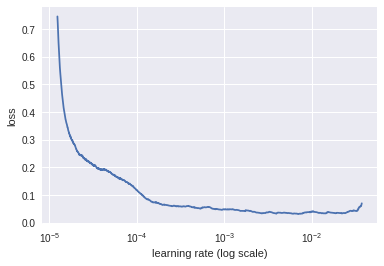

In [0]:
m.sched.plot(100)

Then we can go ahead and call fit. We fit for a while and we are getting something around the 0.1 mark.

In [0]:
m.fit(lr,1,metrics =[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe  
    0      0.014456   0.002733   0.053664  


[array([0.00273]), 0.053664076476623565]

In [0]:
m.fit(lr,3,metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe  
    0      0.011343   0.00205    0.044272  
    1      0.010059   0.008145   0.086297  
    2      0.009174   0.00451    0.064949  


[array([0.00451]), 0.06494872331628185]

In [0]:
m.fit(lr,3,metrics=[exp_rmspe],cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe  
    0      0.00716    1e-06      0.000762  
    1      0.007044   0.00027    0.016304  
    2      0.006425   6e-05      0.007735  


[array([0.00006]), 0.007734752364206504]

So I tried running this on the test set and I submitted it to Kaggle last week, and here it is [39:25](https://youtu.be/5_xFdhfUnvQ?t=2365):

![alt text](https://cdn-images-1.medium.com/max/600/1*YWs_ZIaQ_BbbrrwkpK0j9A.png)

Private score .107, public score .103. So let’s have a look and see how that would go. Let’s start on public:

![alt text](https://cdn-images-1.medium.com/max/600/1*waIe5O1ma5GErcalCNjSug.png)

340th out of 3000. That’s not good. Let’s try the private leader board which is .107.

![alt text](https://cdn-images-1.medium.com/max/600/1*2xzGEay9EGbHhs9HtK-UVg.png)

Oh, 5th [40:30](https://youtu.be/5_xFdhfUnvQ?t=2430). So hopefully you are now thinking oh, there are some Kaggle competition finishing soon which I entered and I spent a lot of time trying to get good results on the public leaderboard. I wonder if that was a good idea. The answer is no, that wasn’t. Kaggle public leaderboard is not meant to be a replacement for your carefully developed validation set. So for example, if you are doing the iceberg competition (which ones are ships, which ones are icebergs), then they’ve actually put something like 4,000 synthetic images into the public leaderboard and none into the private leaderboard. So this is one of the really good kind of things that tests you out on Kaggle is “are you creating a good validation set and are you trusting it?” Because if you are trusting your leaderboard feedback more than your validation feedback, then you may find yourself in 350th place when you thought you are in 5th. In this case, we actually had a pretty good validation set because as you can see, it’s saying somewhere around 0.1 and we actually did get somewhere around 0.1. So in this case, the public leaderboard in this competition was entirely useless.

**Question**: So in regards to that, how much does the top of the public leaderboard actually correspond to the top of a private leaderboard? Because in the churn prediction challenge, there’s like 4 people who are just completely above everyone else [42:07](https://youtu.be/5_xFdhfUnvQ?t=2527). It totally depends. If they randomly sample the public and private leaderboard, then it should be extremely indicative. But it might not be. So in this case, the person who was second on the public leaderboard did end up winning. The first place on the public leaderboard came in 7th. In fact, you can see the little green thing here. Where else, this guy jumped 96 places.

![alt text](https://cdn-images-1.medium.com/max/600/1*BnrOvfaSaTmmJ_Hq0wjW_w.png)

If we had entered with the neural net we just looked at, we would have jumped 350 places. So it just depends. Sometimes they will tell you the public leaderboard was randomly sampled. Sometimes they will tell you it’s not. Generally you have to figure it out by looking at the correlation between your validation set results and the public leaderboard results to see how well they are correlated. Sometimes if 2 or 3 people are way ahead of everybody else, they may have found some kind of leakage or something like that. That’s often a sign that there’s some trick.

Okay, so that’s Rossmann and that brings us to the end of all of our material.



#Review [44:21](https://youtu.be/5_xFdhfUnvQ?t=44m21s)

We’ve learnt two ways to train a model. One is by building a tree and one is with SGD. So the SGD approach is a way we can train a model which is a linear model or stack of linear layers with nonlinearities between them. Whereas tree building specifically will give us a tree. Then tree building, we can combine with bagging to create a random forest or with boosting to create a GBM or various other slight variations such as extremely randomized trees. So it’s worth reminding ourselves of what these things do. So let’s look at some data. Actually, let’s look specifically at categorical data. So categorical data, there’s a couple of possibilities of what categorical data might look like. Let’s say we got zip code, so we’ve got 94003 is our zip code. Then we’ve got like sales, say 50. For 94131, sales of 22, and so forth. So we’ve got some categorical variable. There’s a couple of ways we could represent that categorical variable. One would be just to use the number. Maybe it wasn’t a number to start. Maybe it wasn’t a number at all. Maybe a categorical variable is like San Francisco, New York, Mumbai, and Sydney. But we can turn it into a number just by arbitrarily deciding to give them numbers. So it ends up being a number. We could just use that kind of arbitrary number. So if it turns out that zip codes that are numerically next to each other have somewhat similar behavior then the zip code versus sales chart might look something like this, for example:

![alt text](https://cdn-images-1.medium.com/max/600/1*pD9F59lAzBR0t95uX58nnw.png)

Or alternatively, if the two zip codes next each other didn’t have in any ways similar sales behavior, you would expect to see something that look more like this:

![alt text](https://cdn-images-1.medium.com/max/600/1*rEjCMAtinp8W9ztgRBl6ew.png)

Kind of just all over the place. So they are two possibilities. So what a random forest would do if we just encoded zip in this way is it’s going to say, alright, I need to find my single best split point — the split point that’s going to make the two sides have as smaller standard deviation as possible or mathematically equivalently have the lowest root mean squared error. So in this case, it might pick here as a first split point because on the left side, there’s one average and on the other side, there’s the other average [48:07](https://youtu.be/5_xFdhfUnvQ?t=2887).

![alt text](https://cdn-images-1.medium.com/max/600/1*fjD-QaxNcSvuhYurtZgUjQ.png)

Then finally, it’s going to say how do we split the middle it, and it’s going to say okay I’ll split right in the middle. So you can see that it’s able to hone in on the set of splits it needs even though it kind of does it greedily top down one at a time. The only reason it wouldn’t be able to do this is if it was just such bad luck that the two halves were always exactly balanced. But even if that happens, it’s not going to be the end of the world. It’ll split on something else, some other variable and next time around, it’s very unlikely that it’s still going to be exactly balanced in both parts of the tree. So in practice, this works just fine.

In the second case, it can do exactly the same thing [49:25](https://youtu.be/5_xFdhfUnvQ?t=2965). It’ll say okay which is my best first split even though there’s no relationship between one zip code and its neighboring zip code numerically. We can still see here, if it splits here, there’s the average on one side and the average on the other side is probably about here:

![alt text](https://cdn-images-1.medium.com/max/600/1*qdd-zinp3Ygha0-JUyn04w.png)


Then where would it split next? Probably here, because here is the average on one side, here’s the average on the other side.

![alt text](https://cdn-images-1.medium.com/max/600/1*KWO4ScNhLiS04gL2GLc4hQ.png)

So again, can do the same thing. It’s going to need more splits because it’s going to end up having to narrow down on each individual large zip code and each individual small zip code. But it’s still going to be fine. So when we are dealing with building decision trees for random forests or GBM’s or whatever, we tend to encode our variables just as ordinals.

On the other hand [50:26](https://youtu.be/5_xFdhfUnvQ?t=3026), if we are doing a neural network or like a simplest version like a linear regression or logistic regression, the best it could do is that (in green) which is no good at all:

![alt text](https://cdn-images-1.medium.com/max/600/1*rRolcxROdyRDzpgfSesjqA.png)

And ditto with this one. It’s going to be like that:

![alt text](https://cdn-images-1.medium.com/max/600/1*3w3rV_7V3-nSDXxd_WvJIw.png)

So an ordinal is not going to be a useful encoding for a linear model or something that stacks linear and nonlinear models together. So instead, what we do is we create a one hot encoding. Like so:

![alt text](https://cdn-images-1.medium.com/max/600/1*aQ9lem64E6RL80-pcIq4-Q.png)

With that encoding, that can effectively create like a little histogram where it’s going to have a different coefficient for each level. So that way, it can do exactly what it needs to do.

![alt text](https://cdn-images-1.medium.com/max/600/1*leoafp8fMoOXJw4qZFhvUw.png)

Question: At what point does that become too tedious for your system [51:36](https://youtu.be/5_xFdhfUnvQ?t=3096)? Pretty much never. Because remember, in real life, we don’t actually have to create that matrix. Instead, we can just have the four coefficients and just do an index lookup which is mathematically equivalent to multiply on the one hot encoding. So that’s no problem.

One thing to mention [52:14](https://youtu.be/5_xFdhfUnvQ?t=3134). I know you guys have been taught quite a bit of more analytical solutions to things. And in analytical solutions to like a linear regression, you can’t solve something with this amount of collinearity. In other words, you know something is in Sydney if it’s not Mumbai, New York, or San Francisco. **So in other words, there’s a hundred percent collinearity between the fourth of these classes versus the other three. So if you try to solve a linear regression analytically that way, the whole thing falls apart. Now note with SGD, we have no such problem. Like SGD why would it care? We’re just taking one step along the derivative. It cares a little because in the end, the main problem with collinearity is that there’s an infinite number of equally good solutions. So in other words, we could increase all of these on the left, and decrease this. Or decrease all of these and increase this. And they are going to balance out.**

![alt text](https://cdn-images-1.medium.com/max/600/1*Amkq6DYLYm4XA9tUc2xlVg.png)

And when there’s an infinitely large number of good solutions, it means there’s a lot of flat spots in the loss surface and it can be harder to optimize. So the really easy way to get rid of all those flat spots is to add a little bit of regularization. So if we added a little bit of weight decay, like 1e-7 even, then that says these are not all equally good anymore, the one which is the best is the one where the parameters are the smallest and the most similar to each other, and so that’ll again move it back to being a nice loss function.

**Question**: Could you clarify that point you made about why one hot encoding wouldn’t be that tedious [54:03]? Sure. If we have one hot encoded vector and we are multiplying it by a set of coefficients, then that’s exactly the same thing as simply saying let’s grab the thing where the one is. In other words, if we had stored this (1000) as a zero, 0100 as a one, 0020 as a two, then it’s exactly the same as just saying hey, look up that thing in the array.

![](https://cdn-images-1.medium.com/max/600/1*R7Ii93pRNsAb51pfAhR-bg.png)

So we call that version an embedding. So an embedding is a weight matrix you can multiply by one hot encoding. And it’s just a computational shortcut. But it’s mathematically the same.

There is a key difference between solving linear type model analytically versus with SGD [55:03](https://youtu.be/5_xFdhfUnvQ?t=3303). With SGD, we don’t have to worry about collinearity and stuff, at least not nearly to the same degree. Then the difference between solving a linear or single layer or multi-layer model with SGD versus a tree; a tree is going to complain about less things. So in particular, you can just use ordinals as your categorical variables and as we learnt just before, we also don’t have to worry about normalizing continuous variables for a tree, but we do have to worry about it for these SGD trained models.

Then we also learnt a lot about interpreting, random forests in particular. And if you are interested, you may be interested in trying to use those same techniques to interpret neural nets. If you want to know which of my features are important in a neural net, you could try the same thing; try shuffling each column in turn and see how much it changes your accuracy. That’s going to be your feature importance for your neural net. Then if you really want to have fun, recognize, then, that shuffling that column is just a way of calculating how sensitive the output is to that input which in other words is the derivative of the output with respect to that input. So therefore, maybe you could just ask PyTorch to give you the derivatives with respect to the input directly and see if that gives you the same kind of answers.

You could do the same kind of thing for partial dependence plot. You could try doing the exact same thing with your neural net; replace everything in the column with the same value, do it for 1960, 1961, 1962, plot that. I don’t know if anybody who’s done these things before, not because it’s rocket science but just because maybe no one thought of it or it’s not in a library, I don’t know. But if somebody tried it, I think you should find it useful. It would make a great blog post. Maybe even the paper if you wanted to take it a bit further. So there’s a thought on something you can do. So most of those interpretational techniques are not particularly specific to random forests. Things like the tree interpreter certainly are because they are all about what’s inside the tree.

**Question**: In tree interpreter, we are looking at the paths and their contributions of the features. In neural net case, it will be same with activations, I guess the contributions of each activation on their path [57:42](https://youtu.be/5_xFdhfUnvQ?t=3462)? 
- Yeah, maybe. I don’t know. I haven’t thought about it. Question continued: How can we make inference out of the activations? Jeremy: Be careful saying the word “inference” because people normally use the word inference specifically to mean the same as the test time prediction. You mean kind of interrogate the model. I’m not sure. We should think about that. Actually, Hinton and one of his students just published a paper on how to approximate a neural net with a tree for this exact reason. I haven’t read the paper yet.

**Question**: In linear regression and traditional statistics, one of the things that we focused on was statistical significance of the changes and things like that. So when thinking about a tree interpreter or even like the waterfall chart which I guess is just a visualization. I guess where does that fit in? Because we can see like oh yeah this looks important in the sense that it causes large changes but how do we know that it’s traditionally statistically significant [58:43](https://youtu.be/5_xFdhfUnvQ?t=3523)? 
- So most of the time, I don’t care about the traditional statistical significance and the reason why is that nowadays, the main driver of statistical significance is data volume, not kind of practical importance. And nowadays most of the models you build will have so much data that every tiny thing will be statistically significant but most of them won’t be practically significant. So my main focus, therefore, is practical significance which is does the size of this influence impact your business? Statistical significance was much more important when we had a lot less data to work with. If you do need to know statistical significance because, for example, you have a very small dataset because it’s really expensive to label or hard to collect or whatever, or it’s a medical dataset for a rare disease, you can always get statistical significance by bootstrapping which is to say that you can randomly resample your dataset a number of times, train your model a number of times, and you can then see the actual variation in predictions. So that’s with bootstrapping, you can turn any model into something that gives you confidence intervals. There is [a paper by Michael Jordan](https://arxiv.org/abs/1112.5016) which has a technique called the bag of little bootstraps which actually kind of takes this a little further and well worth reading if you are interested.

**Question**: You said we don’t need one hot encoding matrix if you are doing random forests. What will happen if we do that and how bad can a model be [1:00:46](https://youtu.be/5_xFdhfUnvQ?t=3646)? 
- We actually did do it. Remember we had that maximum category size and we did create one hot encodings, and the reason why we did it was that then our feature importance would tell us the importance of the individual levels and our partial dependence plot, we could include the individual levels. So it doesn’t necessarily make the model worse, it may make it better, but it probably won’t change it much at all. In this case, it hardly changed it. 
**Question continued**: This is something that we have noticed on real data also that if cardinality is higher let’s say 50 levels and if you do one hot encoding, the random forest performs very badly? Jeremy: Yes, thats right. That’s why in Fast.AI, we have maximum categorical size because at some point, your one hot encoded variables become too sparse. So I generally cut it off at 6 or 7. Also because when you get past that, it becomes less useful because for the feature importance, there is going to be too many levels to really look at. 
**Question continued**: can it just not look at those levels which are not important and just give those significant feature as important? Jeremy: Yeah, it will be okay. It’s just like once the cardinality increases too high, you’re just splitting your data up too much basically, and so in practice your ordinal version is likely to be better.

There is no time to review everything but that’s the key concepts and then remembering that the embedding matrix that we can use is likely to have more than just one coefficient, we will actually have a dimensionality of a few coefficients which isn’t going to be useful for most linear models [1:02:42](https://youtu.be/5_xFdhfUnvQ?t=3762). But once you’ve got multi-layer models, that’s now creating a representation of your category which is quite a lot richer and you can do a lot more with it.

# Ethics and Data Science [1:03:13](https://youtu.be/5_xFdhfUnvQ?t=1h3m13s)

[Powerpoint](https://github.com/fastai/fastai/blob/master/courses/ml1/ppt/2017-12-ethics.pptx)

Let’s now talk about the most important bit. We started off early in this course talking about how actually a lot of machine learning is kind of misplaced. People focus on predictive accuracy like Amazon has a collaborative filtering algorithm for recommending books and they end up the book which it thinks you’re most likely to rate highly. So what they end up doing is probably recommending a took that you already have or that you already know about and would have bought anyway which isn’t very valuable. What they should instead have done is to figure out which book can I recommend that would cause you to change your behavior. That way, we actually maximize our lift in sales due to recommendations. So this idea of the difference between optimizing influencing your actions versus just improving predictive accuracy. Improving predictive accuracy is a really important distinction which is very rarely discussed in academia or industry, crazily enough. It’s more discussed in industry, it’s particularly ignored in most academia. So it’s a really important idea which is that in the end the goal of your model, presumably, is to influence behavior. So remember, I actually mentioned [a whole paper I have about this](https://www.oreilly.com/ideas/drivetrain-approach-data-products) where I introduced this thing called the drivetrain approach where I talk about ways to think about how to incorporate machine learning into how do we actually influence behavior. So that’s a starting point, but then the next question is okay if we are trying to influence behavior, what kind of behavior should we be influencing and how and what might it mean when we start influencing behavior. Because nowadays a lot of the companies that you are going to end up working at a big arse companies and you’ll be building stuff that can influence millions of people. So what does that mean?

Actually I’m not going to tell you what it means because I don’t know [1:05:34](https://youtu.be/5_xFdhfUnvQ?t=3934). All I’m going to try and do is make you aware of some of the issues and make you believe two things about them:

1. You should care
2. They are big issue

The main reason I want you to care is because I want you to want to be a good person and show you that not thinking about these things will make you a bad person. But if you don’t find that convincing, I will tell you this. Volkswagen were found to be cheating on their emissions tests. The person who was sent to jail for it was the programmer that implemented that piece of code. They did exactly what they were told to do. So if you are coming in here thinking hey, I’m just a techie, I’ll just do what I’m told, that’s my job. I’m telling you, if you do that, you can be sent to jail for doing what you are told, So a) don’t just do what you’re told because you can be a bad person and b) you can go to jail.

Second thing to realize is, in the head of the moment, you’re in a meeting with twenty people at work and you’re all talking about how you’re going to implement this new feature and everybody is discussing it [1:06:49](https://youtu.be/5_xFdhfUnvQ?t=4009). And everybody’s like “we could do this and here’s a way of modeling it and then we can implement it and here’s these constraints” and there’s some part of you that’s thinking am I sure if we should be doing this? That’s not the right time to be thinking about that because it’s really hard to step up then and say “excuse me I’m not sure this is a good idea”. You actually need to think about how you would handle that situation ahead of time. So I want you to think about these issues now and realize by the time you’re in the middle of it, you might not even realize it’s happening. It’ll just be a meeting like every other meeting and a bunch of people will be talking about how to solve this technical question. You need to be able to recognize oh, this is actually something with ethical implications.

Rachel actually wrote all of these slides. I’m sorry she can’t be here to present this because she has studied this in depth. She’s actually being in difficult environments herself where she’s seen these things happening, an we know how hard it is. But let me give you a sense of what happens.

![](https://cdn-images-1.medium.com/max/600/1*zo37Nh4ky2S1AV9-CcxRAQ.png)

So engineers trying to solve engineering problems and causing problems is not a new thing. In Nazi Germany, IBM, the group known as Hollerith, Hollerith was the original name of IBM and it comes from the guy who actually invented the use of punch cards for tracking the US Census. The first mass wide-scale use of punch cards for data collection in the world. And that turned into IBM, so at this point, was still called Hollerith. So Hollerith sold a punch card system to Nazi Germany and so each punch card would code like this is Jew, 8, gypsy, 12, general execution for death by gas chamber, 6. So here is one of these cards describing the right way to kill these various people. So a Swiss judge ruled that IBM’s technical assistance facilitated the tasks of Nazis and commission of their crimes against humanity. This led to the death of something like twenty million civilians. So according to the Jewish virtual library where I got these pictures and quotes from, their view is that “the destruction of the Jewish people became even less important because of the invigorating nature of IBM’s technical achievement was only heightened by the fantastical profits to be made”. So this was a long time ago and hopefully you won’t end up working at companies that facilitate genocide. But perhaps you will [1:09:59](https://youtu.be/5_xFdhfUnvQ?t=4199).

![](https://cdn-images-1.medium.com/max/600/1*n6tq8aMzyAPRSMcweovFRA.png)

Because perhaps you’ll go to Facebook who are facilitating genocide right now. And I know people at Facebook who are doing this and they had no idea they were doing this. Right now, in Facebook, the Rohingya are in the middle of a genocide, a Muslim population of Myanmar. Babies are grabbed out of their mother’s arms and thrown into fires, people are being killed, hundreds and thousands of refugees. When interviewed, the Myanmar generals doing this said we are so grateful to Facebook for letting us know about the “Rohingya fake news” that these people are actually not human that they are actually animals. Now Facebook did not set out to enable the genocide of the Rohingya in Myanmar, no. Instead, what happened is they wanted to maximize impression in clicks. So it turns out that for the data scientists at Facebook, their algorithms learned that if you take the kinds of stuff people are interested in and feed them slightly more extreme versions of that, you are actually going to get a lot more impressions and the project managers are saying maximize these impressions and people are clicking, and it creates this thing. So the potential implications are extraordinary and global. And this is something that is literally happening. This is October 2017. It’s happening now.

Question: I just want to clarify what was happening here. So it was the facilitation of fake news or inaccurate media [1:11:48](https://youtu.be/5_xFdhfUnvQ?t=4308)? Yeah, let me go into it in more detail, so what happened was in mid 2016, Facebook fired its human editors. So it was humans that decided how to order things on your homepage. Those people got fired and replaced with machine learning algorithms. So the machine learning algorithm written by data scientists like you, they had nice clear metrics and they were trying to maximize their predictive accuracy and be like okay we think if we put this thing higher than this thing, we’ll get more clicks. It turned out that these algorithms for putting things on the Facebook newsfeed had a tendency to say oh, human nature is that we tend to click on things which stimulate our views and are therefore like more extreme versions of things we’ve already seen. This is great for the Facebook revenue model of maximizing engagement, it looked good on all of their KPIs. At that time, there was some negative press about I’m not sure that the stuff that Facebook is now putting on their trending section is actually that accurate, but from the point of view of the metrics that people are optimizing at Facebook, it looked terrific. So way back to October 2016, people started noticing some serious problems.

![](https://cdn-images-1.medium.com/max/600/1*ZWCLP_Uems3djHJFrPFM6Q.png)

For example, it is illegal to target housing to people of certain races in America. That is illegal, and yet a news organization discovered that Facebook was doing exactly that in October 2016. Again, not because somebody in that data science team said “let’s make sure black people can’t live in nice neighborhood.” But instead, they found that their automatic clustering and segmentation algorithm found there was a cluster of people who didn’t like African Americans and if you targeted them with these kinds of ads, then they would be more likely to select this kind of housing or whatever. But the interesting thing is that even after being told about this three times, Facebook still hasn’t fixed it. And that is to say these are not just technical issues. They are also economic issues. When you start saying the thing that you get paid for (that is ads), you have to change the ways that you structure those so that you know you either use more people that cost money, or less aggressive on your algorithms to target people based on minority group status or whatever, that can impact revenues. The reason I mention this is you will at some point in your career find yourself in a conversation where you’re thinking “I’m not confident that this is morally okay”, the person you are talking to is thinking in their head “this is going to make us a lot of money”, you don’t quite ever manage to have a successful conversation because you’re talking about different things. So when you are talking to somebody who may be more experienced and more senior than you and they may sound like they know what they are talking about, just realize that their incentives are not necessarily going to be focused on how so I be a good person. Like they are not thinking how do I be a bad person but the more time you spend in an industry in my experience, the more desensitized you get to this stuff of like maybe getting promotions and making money isn’t the most important thing.

![](https://cdn-images-1.medium.com/max/600/1*Y8FU-fHmFrbTPzt3V-fVvA.png)

